In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy import polyfit

In [2]:
import math
from scipy.stats import norm, chi2

            Date  temp
0     01-01-1981  20.7
1     02-01-1981  17.9
2     03-01-1981  18.8
3     04-01-1981  14.6
4     05-01-1981  15.8
...          ...   ...
3645  27-12-1990  14.0
3646  28-12-1990  13.6
3647  29-12-1990  13.5
3648  30-12-1990  15.7
3649  31-12-1990  13.0

[3650 rows x 2 columns]


Text(0.5, 1.0, 'Minimum daily temperature data from 1981-90')

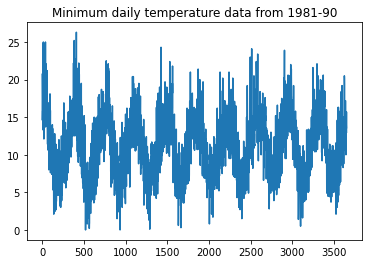

In [16]:
data=pd.read_csv('New Microsoft Excel Worksheet.csv')
print(data)
type(data)
plt.plot(data['temp'])
plt.title('Minimum daily temperature data from 1981-90')

In [17]:
print(data.iloc[1459:1461]) #location of the missing value
print(data.iloc[2919:2921]) #location of the missing value

            Date  temp
1459  30-12-1984  16.4
1460  01-01-1985  13.3
            Date  temp
2919  30-12-1988  14.1
2920  01-01-1989  14.3


In [18]:
mis1=pd.DataFrame({'Date':'31-12-1984','temp':float('NaN')},index=[1460])
mis2=pd.DataFrame({'Date':'31-12-1988','temp':float('NaN')},index=[2921]) 
df=pd.concat([data.iloc[:1460],mis1,data.iloc[1460:2920],mis2,data.iloc[2920:]])#Assigning missing observation date 
df.reset_index(inplace=True)
df=df.iloc[:,1:3]
print(df.shape)
print(df.iloc[1459:1463]) #location of the missing value
print(df.iloc[2920:2923]) #location of the missing value

(3652, 2)
            Date  temp
1459  30-12-1984  16.4
1460  31-12-1984   NaN
1461  01-01-1985  13.3
1462  02-01-1985  15.2
            Date  temp
2920  30-12-1988  14.1
2921  31-12-1988   NaN
2922  01-01-1989  14.3


[14.2, 11.4, 13.7, 16.5, 12.8, 12.2, 12.0, 12.6, 16.0, 16.4, nan, 13.3, 15.2, 13.1, 12.7, 14.6, 11.0, 13.2, 12.2, 14.4, 13.7]


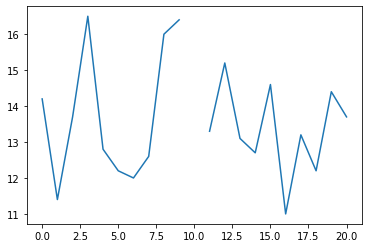

In [19]:
data = df
y1=list(data.iloc[1450:1471,1]) #list of temperature with missing value 
y2=list(data.iloc[2911:2932,1]) #list of temperature with misssing value 
print(y1)
plt.plot(y1) #Plotting the missing observation data plot 

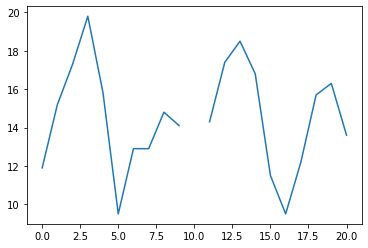

In [20]:
plt.plot(y2) #Plotting the missing observation data plot

16.666666666666668 14.8


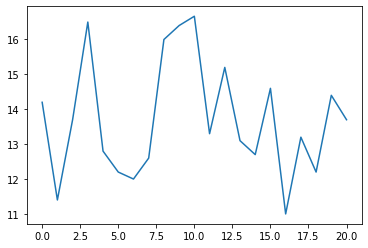

In [21]:
a = np.array([364,729,1094,1460,1825,2190,2555,2921,3286,3651])
y = data.iloc[a,1].values
# to Estimate 31st Dec 1984,1988.we have taken two sided average of 31st Dec temperature with window length of 6 
miss1 = np.mean( np.concatenate((y[0:3],y[4:7])) ) 
miss2 = np.mean( np.concatenate((y[4:7],y[8:11])) )
print(miss1,miss2)
data.iloc[1460,1] = miss1
data.iloc[2921,1] = miss2
y1 = list(data.iloc[1450:1471,1])
y2 = list(data.iloc[2911:2932,1])
plt.plot(y1) #Plot of the observation along with estimated missing data values 

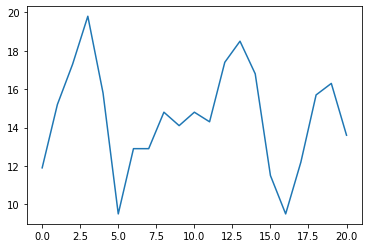

In [22]:
plt.plot(y2) #Plot of the observation along with estimated missing data values 

In [23]:
#Dividing data into train data(1981-88) and test data(1989-90) 
train=data.iloc[:2922,:]
test=data.iloc[2922:,:]
print(train.shape,test.shape)
print(train.iloc[:,1:2])

(2922, 2) (730, 2)
      temp
0     20.7
1     17.9
2     18.8
3     14.6
4     15.8
...    ...
2917  12.9
2918  12.9
2919  14.8
2920  14.1
2921  14.8

[2922 rows x 1 columns]


In [24]:
y=list(train.iloc[:,1]) #temperature values of train data

In [25]:
#Now Onwards working with the train data and try to identify suitable model for the data
#First Checking whether trend,seasonality is present in data or not 
#using Relative ordering test to check whether trend is present in data or not 
def relative_ordering(Temp,alpha):
    Q=0
    n=len(Temp)
    for i in range(n):
        for j in range(i+1,n):
            if(Temp[i]-Temp[j]>0):
                Q+=1
    print('Q=',Q)
    T=1-4*Q/(n*(n-1))
    VT=2*(2*n+5)/(9*n*(n-1))
    Z=T/math.sqrt(VT)
    t=norm.ppf(1-alpha/2)
    print('Z=',Z)
    print('t_alpha/2=',t)
    if(abs(Z)<=t):
        print('So, Trend is not present')
    else:
        print('Trend is present')

In [26]:
relative_ordering(y,0.05)

Q= 2119471
Z= 0.5438102724382543
t_alpha/2= 1.959963984540054
So, Trend is not present


In [27]:
#Checking the presence of seasonality using friedman test 
def friedman(temp,r_val,c,alpha):
    r=[]
    for i in range(1,9):
        if(i<5):
            year=temp[365*(i-1):i*365]
        else:
            year=temp[365*(i-1)+1:i*365+1]
        year=np.array(year)
        ran=pd.Series(year)
        ran=ran.rank()
        r.append(ran)
    s=np.array(sum(r))
    m=c*(r_val+1)/2
    v=c*r_val*(r_val+1)
    X=12*sum((s-m)**2)/v
    print('X=',X)
    chi_square=chi2.ppf(1-alpha,r_val-1)
    print('Chi square value ',chi_square)
    if(X>chi_square):
        print('Seasonality is present')
    if(X<=chi_square):
        print('No Seasonality')

In [32]:
friedman(y,365,8,0.05)

X= 1792.4236132944084
Chi square value  409.48819000584814
Seasonality is present


In [33]:
#Checking whether series is purely random or not using relative ordering test
def turning_point(temp,alpha):
    P=0
    n=len(temp)
    for i in range(1,n-1):
        if((temp[i]>temp[i-1] and temp[i]>temp[i+1]) or (temp[i]<temp[i-1] and temp[i]<temp[i+1])):
            P+=1
    print('P=',P)
    EP=2*(n-2)/3
    VP=(16*n-29)/90
    Z=(P-EP)/math.sqrt(VP)
    print("Z=",Z)
    t=norm.ppf(1-alpha/2)
    print('t_alpha/2=',t)
    if(abs(Z)>t):
        print('Series is not purely Random')
    else:
        print('Series is purely Random')

In [34]:
turning_point(y,0.05)

P= 1586
Z= -15.829306948103918
t_alpha/2= 1.959963984540054
Series is not purely Random


In [35]:
temp=y
#Estimating the Seasonality using perfect polynomial fitting
x=[]
# fit polynomial: x*b1 + x^2*b2 + ... + bn
for i in range(1981,1989):
    if(i%4==0):
        for j in range(0,366):
            x.append(j)
    else:
        for j in range(0,365):
            x.append(j)
print(len(x))
y = temp
degree = 4
coef = polyfit(x, y, degree)
print('Coefficients: %s' % coef)
# create curve
curve = list()
for i in range(len(x)):
    value = coef[-1]
    for d in range(degree):
        value += x[i]**(degree-d) * coef[d]
    curve.append(value)

2922
Coefficients: [-1.09432844e-08  8.68462851e-06 -2.00352919e-03  1.05990552e-01
  1.40060976e+01]


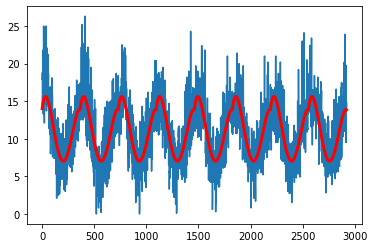

In [39]:
 # plot curve over original data
plt.plot(data.temp[1:2922])
plt.plot(curve, color='red', linewidth=3)
plt.show()

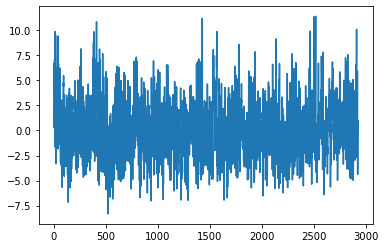

In [42]:
# Deseasonalized Data Plot 
values = y
diff = list()
for i in range(len(values)):
    value = values[i] - curve[i]
    diff.append(value)
plt.plot(diff)
plt.show()


In [43]:
#Checking Seasonality of deseasonalized data 
friedman(diff,365,8,0.05)

X= 349.430878059735
Chi square value  409.48819000584814
No Seasonality


In [44]:
#Checking randomness of deseasonalized data
turning_point(diff,0.05)

P= 1629
Z= -13.9420790402431
t_alpha/2= 1.959963984540054
Series is not purely Random


In [45]:
#Augmented Dickey-Fuller test for testing stationarity
from statsmodels.tsa.stattools import adfuller
X = diff
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    if result[1]<0.05:
        print("data series is stationary")
    else:
        print("data series is not stationary")


ADF Statistic: -16.043912
p-value: 0.000000
Critical Values:
	1%: -3.433
data series is stationary
	5%: -2.863
data series is stationary
	10%: -2.567
data series is stationary


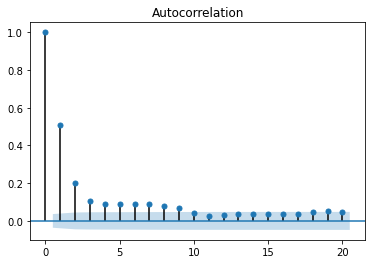

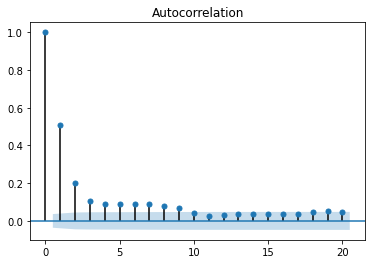

In [46]:
# Plot ACF in Python
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff, lags=20, alpha=0.05)

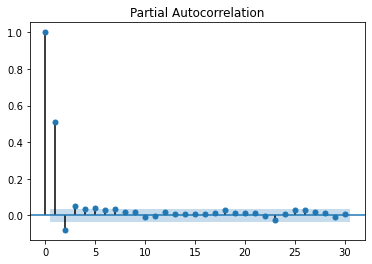

In [47]:
plot_pacf(diff,lags=30);

In [48]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: threadpoolctl>=2.0.0 in c:\users\rajat\anaconda3\lib\site-packages (from scikit-learn>=0.22->pmdarima) (2.1.0)



In [49]:
from pmdarima.arima import auto_arima
stepwise_fit = auto_arima(diff , trace =True ,suppress_warninigs =True)
stepwise_fit.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=13441.093, Time=6.97 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14286.305, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14185.444, Time=0.32 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14007.694, Time=1.36 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14284.306, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=13439.256, Time=3.37 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=13502.981, Time=1.56 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.14 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=13440.899, Time=6.18 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=13446.904, Time=2.79 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=13441.725, Time=2.98 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=13443.189, Time=4.62 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=13437.291, Time=1.01 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=13501.029, Time=0.51 sec
 ARIMA(1,1,1)(0,0,0)[0]  

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2922
Model:               SARIMAX(1, 1, 2)   Log Likelihood               -6714.645
Date:                Wed, 23 Dec 2020   AIC                          13437.291
Time:                        00:24:08   BIC                          13461.210
Sample:                             0   HQIC                         13445.906
                               - 2922                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3364      0.034      9.842      0.000       0.269       0.403
ma.L1         -0.7867      0.036    -21.871      0.000      -0.857      -0.716
ma.L2         -0.1991      0.035     -5.722      0.000      -0.267      -0.131
sigma2         5.8044      0.146     39.867      0.000       5.519       6.090
===================================================================================
Ljung-Box (Q):                       35.25   Jarque-Bera (JB):                 9.20
Prob(Q):                              0.68   Prob(JB):                         0.01
Heteroskedasticity (H):               0.90   Skew:                             0.09
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
train.shape
train.head(5)
#test.shape
model = ARIMA(diff,order=(3,1,9))
model = model.fit()
model.summary()

In [246]:
start =len(train)
end = len(train)+len(test)-1
pred = model.predict(start=start ,end = end ,typ='levels')
print(pred)

[1.04342225 1.07157094 0.65647691 0.67779477 0.98480282 0.65480234
 0.63182405 0.95631423 0.67965001 0.5834472  0.93057226 0.71039059
 0.5450912  0.89904158 0.7444112  0.51726001 0.8620805  0.77921804
 0.50022489 0.82050134 0.81249439 0.49396588 0.77548845 0.84216101
 0.49813606 0.72850918 0.8664341  0.5120482  0.68121999 0.8838767
 0.53468251 0.63537036 0.89343981 0.56471398 0.59270752 0.89449046
 0.60055694 0.55488539 0.88682465 0.64042404 0.52338086 0.870664
 0.68239621 0.4994206  0.8466358  0.72450024 0.483921   0.8157369
 0.76478981 0.47744354 0.77928295 0.80142632 0.48016712 0.73884472
 0.83275556 0.49187835 0.69617445 0.85737666 0.51197985 0.65312514
 0.87420029 0.53951602 0.61156636 0.88249326 0.57321502 0.57330009
 0.88190769 0.61154473 0.53998026 0.87249338 0.65278038 0.51303951
 0.85469281 0.69508045 0.49362617 0.8293191  0.73656766 0.48255429
 0.79751787 0.77541129 0.48026873 0.76071477 0.80990717 0.48682678
 0.72055099 0.83855184 0.50189708 0.67880964 0.86010765 0.52477567

In [247]:
s_comp=curve[0:730]
len(s_comp)
pred1=pred+s_comp


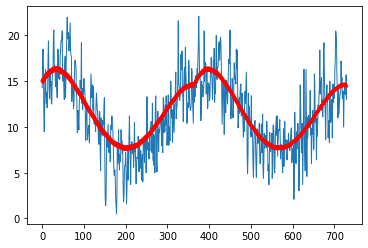

In [251]:
test = list()
for i in range(730):
    test1 = data.temp[2922+i]
    test.append(test1)
pyplot.plot(test,linewidth=1)
pyplot.plot(pred1, color='red', linewidth=3)
pyplot.show()
ee=test-pred1

P= 397
Z= -7.7636200474177
t_alpha/2= 1.959963984540054
Series is not purely Random


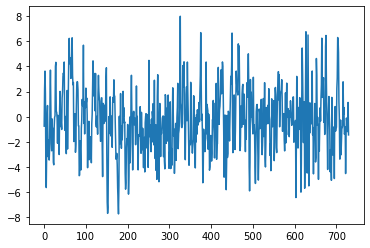

In [254]:
plt.plot(ee)
turning_point(ee,0.05)

In [250]:
sum=0
for i in range(len(test)):
    sum=sum+(test[i]-pred1[i])**2
print("sum=",sum)
RMSE=math.sqrt(sum/len(test))
print("RMSE=",RMSE)


sum= 4732.102373333592
RMSE= 2.5460424227151432
